In [48]:
#NN Surrogate model class
from injector_surrogate_quads import *
import physics_gp
import os

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

#Pytorch 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gpytorch
import botorch 

import matplotlib.pyplot as plt

random_seed = 1
torch.manual_seed(random_seed)

# BO with Expressive Priors - Neural Networks

In [49]:
Model = Surrogate_NN(pytorch=True)

Model.load_saved_model(model_path = '../models/', 
                       model_name = 'Surrogate_NN_PyTorch')

Model.load_scaling(scalerfilex = '../data/transformer_x_pytorch.pth', 
                   scalerfiley = '../data/transformer_y_pytorch.pth')
Model.take_log_out = False

In [50]:
# design Twiss parameters 
beamline_info = json.load(open('../configs/beamline_info.json'))
get_twiss0 = beamline_info['Twiss0']

# emit, beta, alpha
twiss0 = {'x': [get_twiss0[0], get_twiss0[2], get_twiss0[4]],
          'y': [get_twiss0[1], get_twiss0[3], get_twiss0[5]]}

beta0_x, alpha0_x = twiss0['x'][1], twiss0['x'][2]
beta0_y, alpha0_y = twiss0['y'][1], twiss0['y'][2]
# print(twiss0['x'], twiss0['y'])

## Objective Function

In [51]:
# convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

# input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]
bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

In [52]:
def evaluate(config): 
    """
    D is input space dimensionality
    N is number of sample points
    :param config: input values of opt_var_names, torch.tensor, shape (N, D) 
    returns (N, 1) 
    """
    N = config.shape[0]
    D = config.shape[1]
    
    # make input array of length model_in_list (inputs model takes)
    x_in = torch.empty((N,len(Model.model_in_list)))
    
    # fill in reference point around which to optimize
    x_in[:,:] = torch.tensor(ref_point[0])

    #set solenoid, CQ, SQ, matching quads to values from optimization step
    col = []
    for i in range(D):
        col.append(Model.loc_in[opt_var_names[i]]) #should make col a flat list of indices, e.g. [4, 6, 7]
    x_in[:, col] = config[:,:] 
    
    #output predictions
    y_out = Model.pred_machine_units(x_in)

    return -1*objective(y_out)


def objective(y_out):
    """
    :param y_out: tensor with has a shape of (N, num_outputs)
    returns tensor of emittance * bmag for each input, shape (N, 1)
    """
    
    # geometric emittance in transverse plane
    out1 = y_out[:,Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    out2 = y_out[:,Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    emit = torch.sqrt(out1 * out2)
  
    sigma_x = y_out[:,Model.loc_out['sigma_x']] #grab sigma_x out of the model 
    sigma_y = y_out[:,Model.loc_out['sigma_y']] #grab sigma_y out of the model 
    
    # real beta and alpha 
    # NEEDS TO BE FIXED - currently assuming real alpha to be the same as design alpha 
    alpha_x = torch.tensor(alpha0_x).repeat(y_out.shape[0])
    alpha_y = torch.tensor(alpha0_y).repeat(y_out.shape[0])
    beta_x, beta_y = (sigma_x**2) / out1, (sigma_y**2) / out2
    
    # bmag 
    bmag_x = 0.5 * ((beta0_x / beta_x) + (beta_x / beta0_x)) + 0.5 * ((alpha_x * torch.sqrt(beta0_x / beta_x) - alpha0_x * torch.sqrt(beta_x / beta0_x))**2)
    bmag_y = 0.5 * ((beta0_y / beta_y) + (beta_y / beta0_y)) + 0.5 * ((alpha_y * torch.sqrt(beta0_y / beta_y) - alpha0_y * torch.sqrt(beta_y / beta0_y))**2)
    bmag = torch.sqrt(bmag_x * bmag_y)
    
    out = (emit * bmag)/1e-6 # in um units 
    return out.reshape(-1,1)

torch.Size([255569, 9]) torch.Size([255569, 1])
tensor([[ -6.9780],
        [-13.1325],
        [ -6.2232],
        ...,
        [ -6.4434],
        [ -7.1440],
        [ -7.3886]])


(array([  135.,   122.,   116.,   153.,   140.,   135.,   162.,   163.,
          148.,   168.,   173.,   184.,   170.,   187.,   199.,   175.,
          225.,   211.,   245.,   205.,   258.,   249.,   236.,   285.,
          297.,   281.,   286.,   323.,   308.,   338.,   320.,   347.,
          337.,   401.,   406.,   369.,   432.,   439.,   426.,   415.,
          468.,   490.,   513.,   545.,   595.,   608.,   647.,   636.,
          670.,   751.,   766.,   805.,   753.,   818.,   889.,   932.,
          995.,  1143.,  1133.,  1178.,  1354.,  1397.,  1510.,  1544.,
         1575.,  1847.,  1855.,  2015.,  2268.,  2278.,  2598.,  2775.,
         2950.,  3225.,  3311.,  3650.,  3935.,  4254.,  4678.,  4992.,
         5389.,  5918.,  6382.,  6953.,  7304.,  8056.,  8721.,  9536.,
        10192., 10876., 11639., 12328., 12894., 13038., 12812., 11801.,
         9921.,  7422.,  3878.,   994.]),
 array([-19.999994 , -19.805773 , -19.611551 , -19.417332 , -19.22311  ,
        -19.028889 , 

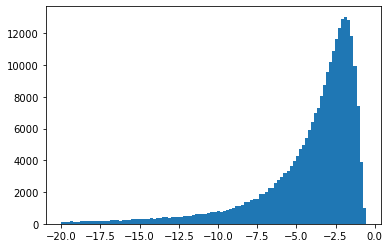

In [53]:
# mesh grid of n_samples_per_var^n_var points to sample
n_samples_per_var = 4
n_var = 9
cutoff = False 
cutoff_val = -5 # restrict outputs to [-5, 0]


# create x and y if they are not saved in file, otherwise load x and y from grid.pt
filename = f'grid{n_samples_per_var}^{n_var}.pt'

# create input and output data
if os.path.exists('./results/'+filename) and os.stat('./results/'+filename).st_size > 0: 
    training_dict = torch.load('./results/'+filename)
    x = training_dict['x']
    y = training_dict['y']
else: 
    # take n_samples_per_var points from each dimension i
    var_points = torch.zeros((n_var, n_samples_per_var))
    for i in range(n_var):
        var_points[i,:] = torch.linspace(bounds[i,0],bounds[i,1],n_samples_per_var)

    # generate grid of points to sample 
    grid = np.array(np.meshgrid(*var_points)).reshape(n_var,-1)

    x = (torch.tensor(grid).t())
    
    # evaluate grid training points in batches 
    x_data = torch.utils.data.TensorDataset(x)
    x_loader = torch.utils.data.DataLoader(x_data, batch_size=3**9, shuffle=False)
    
    y = torch.cat([evaluate(x_sample[0]).detach() for batch_idx, x_sample in enumerate(x_loader)])
    torch.save({'x': x, 'y': y}, './results/'+filename)

# preprocessing - remove very large values that may interfere with training 
x = x[torch.where(y > -20)[0]] if cutoff == False else x[torch.where(y > cutoff_val)[0]]
y = y[torch.where(y > -20)[0]] if cutoff == False else y[torch.where(y > cutoff_val)[0]]
print(x.shape, y.shape)
print(y)

# see output distribution 
plt.hist(y.numpy(), bins = 100)

## Fit data with a Neural Network

In [54]:
batch_size = 1024

# normalize input and output data
transformer_x = botorch.models.transforms.input.Normalize(n_var, bounds = bounds.transpose(0,1))
normed_x = transformer_x(x)
print(normed_x.shape)

transformer_y = botorch.models.transforms.input.Normalize(1)
transformer_y.train()
normed_y = transformer_y(y)
transformer_y.eval()
# print(torch.min(y), torch.max(y))

# save transformer_y for this model
transformer_y_name = f'transformer_y_{n_samples_per_var}^{n_var}' if cutoff == False else f'{n_samples_per_var}^{n_var}_{cutoff_val}'
print('saving ' + transformer_y_name)
torch.save(transformer_y.state_dict(), f'./results/{transformer_y_name}.pth') 

use_valid = True

data = torch.utils.data.TensorDataset(normed_x.float(), normed_y.float())

# create training and/or valid datasets
if use_valid == True:
    train_size = int(0.8 * len(data))
    valid_size = len(data) - train_size
    train_data, valid_data = torch.utils.data.random_split(data, [train_size, valid_size])
    print(len(train_data), len(valid_data))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
else:
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    valid_loader = None

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape, example_targets.shape)

torch.Size([255569, 9])
saving transformer_y_4^9
204455 51114
torch.Size([1024, 9]) torch.Size([1024, 1])


In [55]:
# model 
class NN_prior(nn.Module):
    def __init__(self):
        super(NN_prior, self).__init__()
        
        hidden_size = 30
        self.network = nn.Sequential(nn.Linear(n_var, hidden_size), 
                                     nn.Tanh(), 
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, hidden_size),
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, 1))
        
        
    def forward(self, x):
        x = self.network(x)
        return x 

In [56]:
log_interval = 20
model_name = 'model4_3hidden_30nodes_500epoch_0.01'
def train_model(model, epochs, train_loader, valid_loader, optimizer, scheduler):
    """
    trains the NN model and tests the model on validation dataset every epoch
    returns training and validation losses as arrays
    :param model: model to be trained
    :param epochs: number of epochs to train model
    :param train_loader: training dataset
    :param valid_loader: validation dataset
    :param optimizer: update model parameters during training to minimize loss function
    :param scheduler: implements learning rate decay
    :returns train losses and valid losses: losses per training iteration per epoch
    """
    train_losses = []
    valid_losses = []
    best_valid = 1e8
    
    for epoch in range(epochs):
        ######### train #########
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad() 
            output = model(data) 
            
            loss = F.mse_loss(output, target) 
            loss.backward()
            
            optimizer.step() 
            
            if epoch % log_interval == 0 and batch_idx % 50000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            
        ######### validate #########   
        if valid_loader != None:
            model.eval()
            valid_loss = 0.0
            for batch_idx, (data, target) in enumerate(valid_loader):
                output = model(data) 
                valid_loss += (output - target).pow(2).sum()

            valid_loss = valid_loss / valid_size
            valid_losses.append(valid_loss.detach()) 

            #save model if highest validation score 
            if (valid_loss < best_valid):
                # print("Saved model!")
                best_valid = valid_loss       
                torch.save(model.state_dict(), './results/'+ model_name + '.pth') 
                torch.save(optimizer.state_dict(), './results/optimizer.pth')
            if scheduler != None:
                scheduler.step(valid_loss.detach())
        else:
            torch.save(model.state_dict(), './results/'+ model_name + '.pth') 
            torch.save(optimizer.state_dict(), './results/optimizer.pth')
    return train_losses, valid_losses


In [57]:
train_new_model = False
plot_loss = True

if train_new_model == True:
    print('Training ' + model_name)
    NN_prior_model = NN_prior()
    NN_optimizer = optim.Adam(NN_prior_model.parameters(), lr = 0.01)
    NN_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(NN_optimizer, 'min')
    n_epochs = 1000
    train_losses, valid_losses = train_model(NN_prior_model, n_epochs, train_loader, valid_loader, NN_optimizer, NN_scheduler)

    #plot training/valid loss
    if plot_loss == True:
        fig, ax = plt.subplots()
        fig.set_size_inches(15, 5)
        if train_new_model == True and use_valid == True:
            ax.set_title("valid loss")
            ax.set(ylim=(0.0, 0.1))
            ax.semilogy(valid_losses, label = "log_valid")
        elif train_new_model == True:
            ax.set_title("training loss")
            ax.plot(train_losses, label = "train")
        fig.legend()

## Scan

In [58]:
# load model
# model_name = 'model5_4hidden_40nodes_1000epoch_0.01_-5'
NN_model = NN_prior()
NN_model.load_state_dict(torch.load('./results/'+ model_name + '.pth'))
NN_model.eval()

NN_prior(
  (network): Sequential(
    (0): Linear(in_features=9, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): Tanh()
    (8): Linear(in_features=30, out_features=1, bias=True)
  )
)

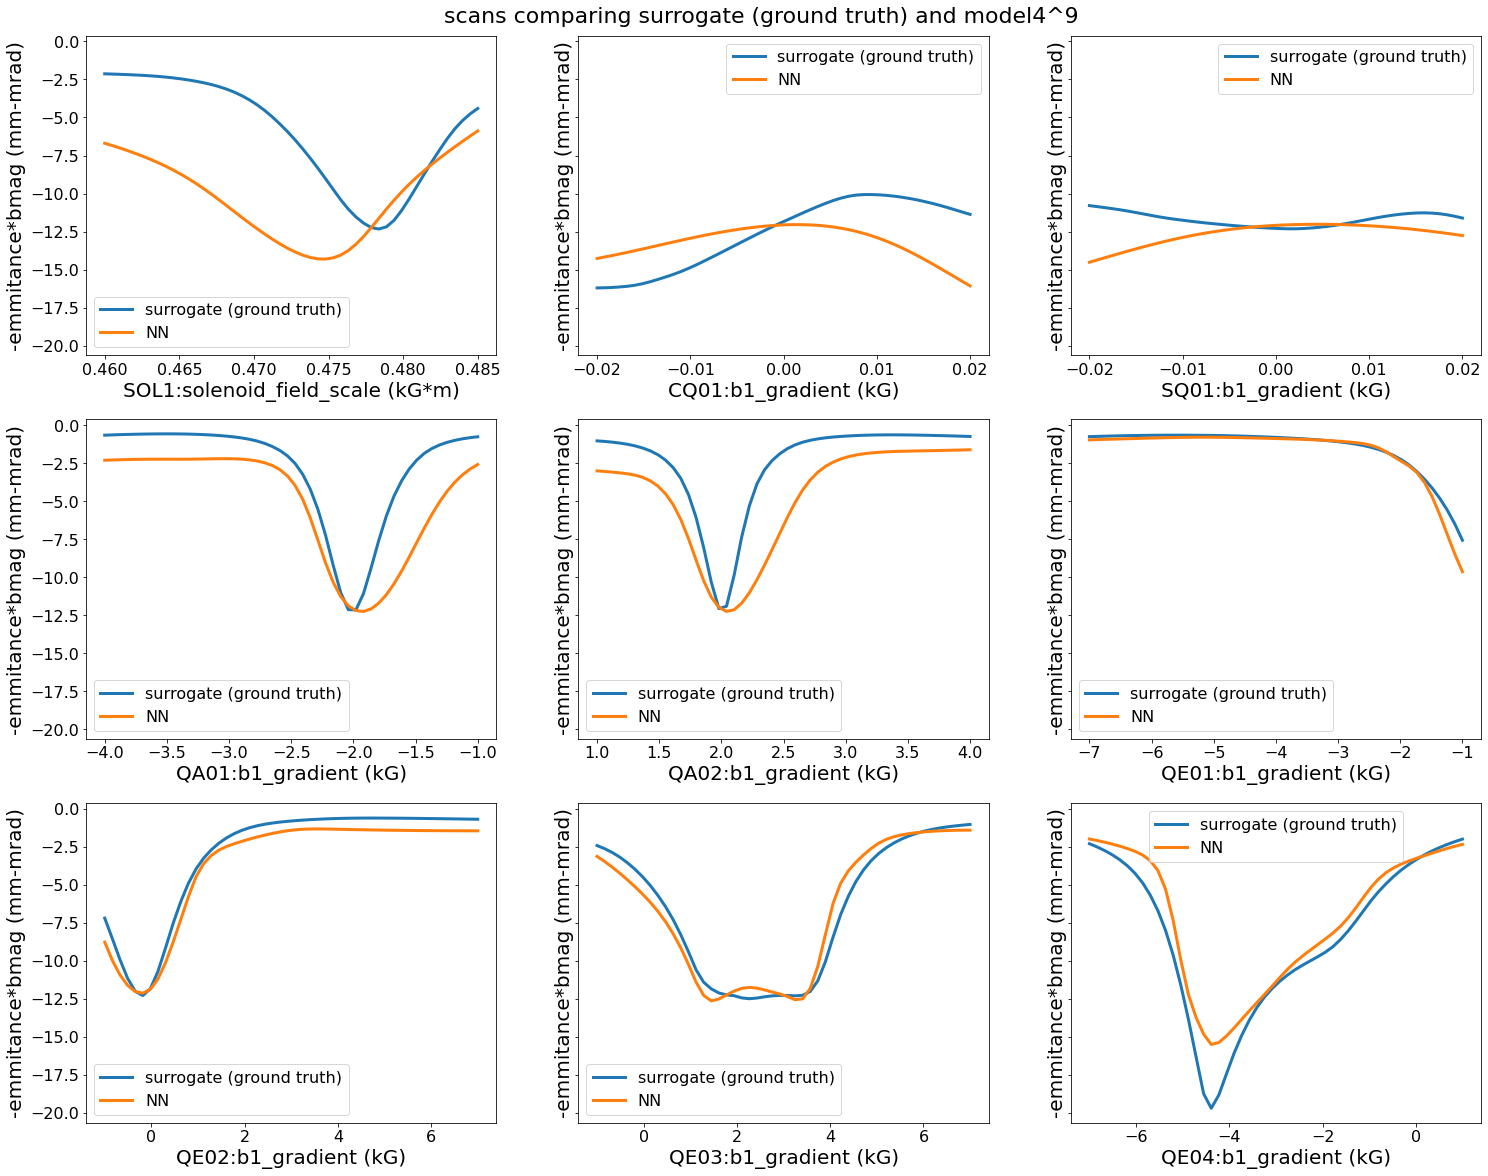

In [59]:
# bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
#                        [-4, -1], [1, 4],
#                        [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# use ref point values for the parameters that are kept constant 
scan_ref_point = torch.cat([torch.as_tensor([ref_point[0][Model.loc_in[param_name]]]) for param_name in opt_var_names])

# scan_ref_point[0] = 0.47645
# scan_ref_point[1] = -0.00975
# scan_ref_point[2] = 0.00917 
# scan_ref_point[3] = -3.79410
# scan_ref_point[4] = 2.00556
# scan_ref_point[5] = -2.67074
# scan_ref_point[6] = 4.38737
# scan_ref_point[7] = -0.49207
# scan_ref_point[8] = -6.12455

def scan(param_name, num_scans, model_prior):
    """
    scans values across a single parameter of the model, keeping others constant
    :param param_name: name of the model param that is being scanned, string, size 1 
    :param num_scans: number of values scanned for parameter 
    :returns real_test_y: ground truth scan outputs 
    :returns model_test_y: model scan outputs
    """ 
    param_index = opt_var_names.index(param_name)
    
    test_x = scan_ref_point.repeat(num_scans, 1) 
    test_x[:,param_index] = torch.linspace(bounds[param_index, 0], bounds[param_index, 1], num_scans)
    
    real_test_y = evaluate(test_x.float()).detach()
    normed_model_test_y = model_prior(transformer_x(test_x).float()).detach()
    model_test_y = transformer_y.untransform(normed_model_test_y)
    
    return real_test_y, model_test_y, test_x

fig, axes = plt.subplots(3, 3, sharey=True)
fig.suptitle("scans comparing surrogate (ground truth) and " + model_name[:6] + '^9', x=0.5, y=0.90, fontsize=22)
fig.set_size_inches(25,20)

# plot scans for each input variable
for i, ax in enumerate(fig.axes):
    param_name = opt_var_names[i] 

    # get scan ouputs
    real_test_y, model_test_y, test_x = scan(param_name, 50, NN_model) 

    units = 'kG*m' if param_name == 'SOL1:solenoid_field_scale' else 'kG'
    ax.set_xlabel(f'{param_name} ({units})', fontsize=20)
    ax.set_ylabel('-emmitance*bmag (mm-mrad)', fontsize=20)

    ax.plot(test_x[:,opt_var_names.index(param_name)], real_test_y, label = "surrogate (ground truth)", linewidth=3)
    ax.plot(test_x[:,opt_var_names.index(param_name)], model_test_y, label = "NN", linewidth=3)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    ax.legend(fontsize=16)
